In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

2024-01-26 15:06:58.305400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
def create_data():
    images = []
    final = []
    label = []
    name = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
    for dis in name:
        folder_path = 'Corn Images/' + dis
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            images.append(img)
            label.append(dis)
    final.append(images)
    final.append(label)
    return final

In [4]:
result = create_data()
dataset = pd.DataFrame({'Images': result[0], 'Label': result[1]})

In [5]:
print(dataset[dataset['Label'] == 'Blight'].count())
print(dataset[dataset['Label'] == 'Common_Rust'].count())
print(dataset[dataset['Label'] == 'Gray_Leaf_Spot'].count())
print(dataset[dataset['Label'] == 'Healthy'].count())

Images    1146
Label     1146
dtype: int64
Images    1306
Label     1306
dtype: int64
Images    574
Label     574
dtype: int64
Images    1162
Label     1162
dtype: int64


In [6]:
dataset[:100]

,Images,Label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
...,...,...
95,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
96,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
97,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
98,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight


In [7]:
def Resize(content):
    return content.resize((224, 224))

In [8]:
dataset['Resized Image'] = dataset['Images'].apply(Resize)

In [9]:
dataset[:100]

,Images,Label,Resized Image
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight,<PIL.Image.Image image mode=RGB size=224x224 a...
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight,<PIL.Image.Image image mode=RGB size=224x224 a...
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight,<PIL.Image.Image image mode=RGB size=224x224 a...
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight,<PIL.Image.Image image mode=RGB size=224x224 a...
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight,<PIL.Image.Image image mode=RGB size=224x224 a...
...,...,...,...
95,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight,<PIL.Image.Image image mode=RGB size=224x224 a...
96,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight,<PIL.Image.Image image mode=RGB size=224x224 a...
97,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight,<PIL.Image.Image image mode=RGB size=224x224 a...
98,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight,<PIL.Image.Image image mode=RGB size=224x224 a...


In [10]:
def show_image(image):
    image = image.copy()
    plt.imshow(image, aspect='equal')

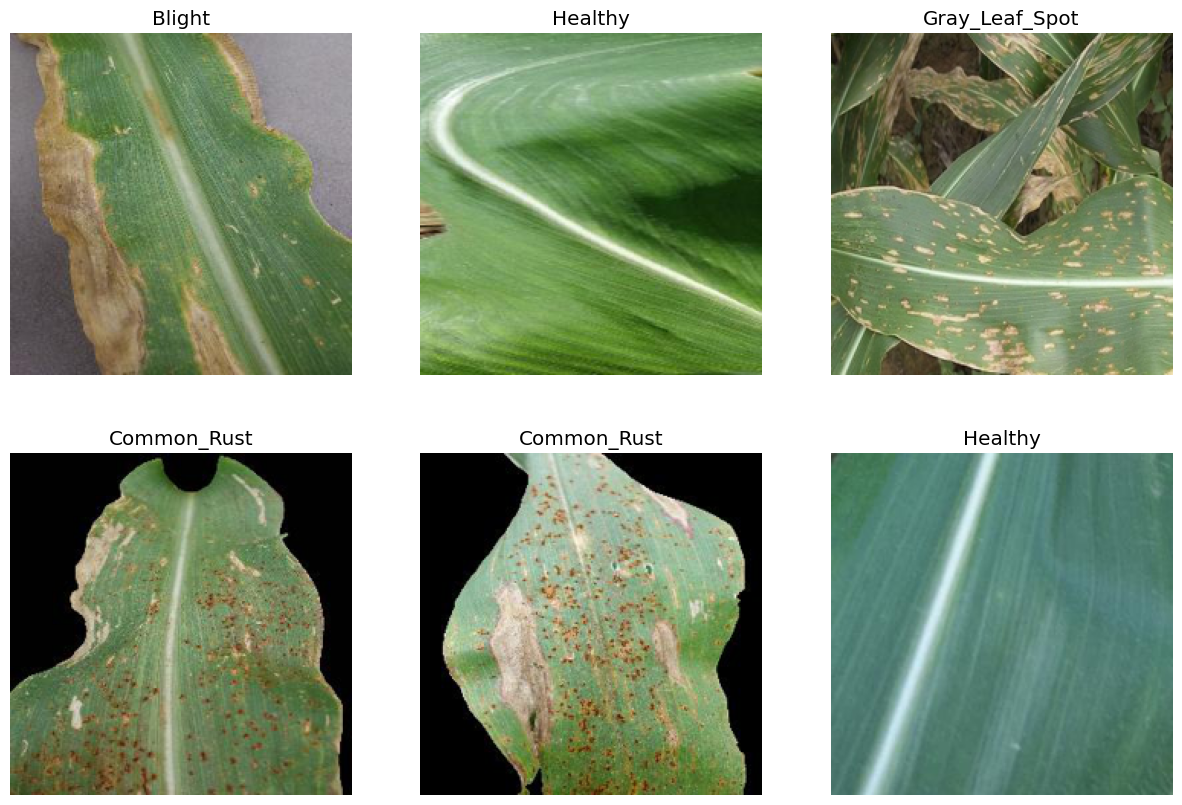

In [11]:
rng = np.random.default_rng(42)
n_cols = 3
n_rows = 2
indexes = rng.choice(len(dataset), n_cols * n_rows)

plt.figure(figsize=(15, 10))

for ii, id in enumerate(indexes, 1):
    plt.subplot(n_rows, n_cols, ii)
    image = dataset['Resized Image'][int(id)]
    show_image(image)
    plt.title(dataset['Label'][int(id)])
    plt.axis('off')

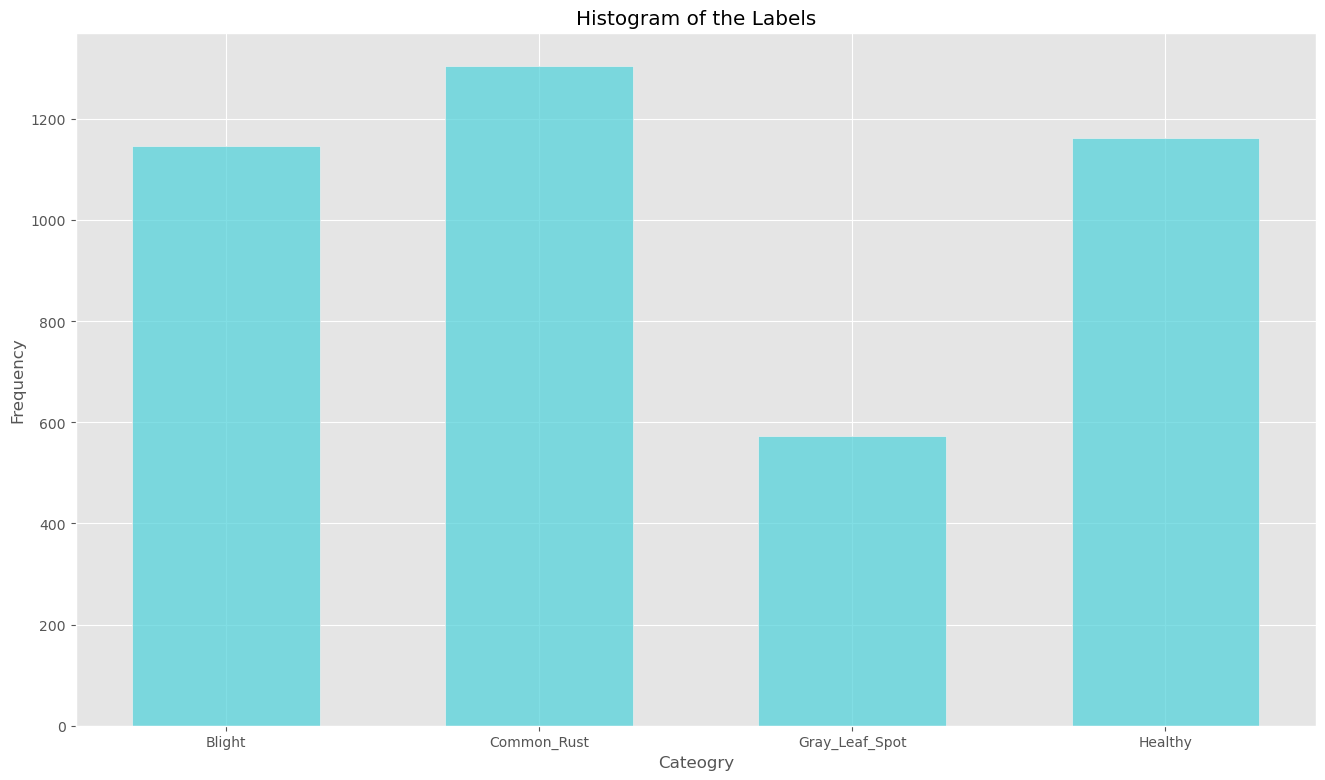

In [12]:
palette = sns.color_palette('hls', 4)

plt.figure(figsize=(16, 9))
sns.histplot(dataset['Label'], bins=4, shrink=0.6, kde=False, color=palette[2])

plt.xlabel('Cateogry')
plt.ylabel('Frequency')
plt.title('Histogram of the Labels')

# Show the plot
plt.show()

In [13]:
def ToTensor(content):
    return tf.convert_to_tensor(np.array(content))

In [14]:
dataset['Tensor Image'] = dataset['Resized Image'].apply(ToTensor)

In [15]:
dataset.head()

KeyboardInterrupt: 